In [1]:
import scanpy as sc

In [2]:
import pandas as pd
import numpy as np
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
import os

In [4]:
import matplotlib.pyplot as plt

In [5]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

### Prepare sc data

In [6]:
adata = sc.read('zenodo/pancreas_tumor.h5ad')

In [8]:
adata.obs['label'] = adata.obs['level2_cell_type']

In [10]:
adata.obs['replicate'] = adata.obs['dataset']

In [13]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [14]:
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")

In [15]:
del adata.obsp
del adata.uns
adata.obsm.pop('X_scANVI')
adata.obsm.pop('X_scVI')

array([[ 1.3974355 ,  2.4972777 , -1.1957159 , ...,  0.45253196,
         1.3370308 ,  0.35014474],
       [ 2.7808785 ,  0.93263936,  0.2726134 , ..., -0.43241626,
         1.0083345 ,  0.09686909],
       [ 0.38637084,  1.6929334 , -1.141629  , ..., -0.23925972,
         1.4754397 ,  0.6945904 ],
       ...,
       [-1.1108016 , -0.88036937,  1.1173542 , ..., -0.27276796,
         0.45323557, -1.2302313 ],
       [-1.0485637 , -0.7634794 ,  0.7107538 , ..., -0.125734  ,
         0.50533545, -0.48691663],
       [-1.4628317 , -0.66777253,  1.0964521 , ..., -0.6832974 ,
        -0.04516396, -0.50682956]], dtype=float32)

In [16]:
adata.obs['cellstate'] = adata.obs['label']

In [17]:
cellstate_celltype_dict = {'B cells' : 'B cells', 'CD56bright NK cells' : 'NK cells', 'CD56dim NK cells' : 'NK cells', 'Dendritic cells' : 'Myeloid',
       'Endothelial cells' : 'Endothelial cells', 'Fibroblasts' : 'Fibroblasts', 'ILCs' : 'ILCs', 'MAIT cells' : 'T cells', 'Macrophages' : 'Myeloid',
       'Melanoma cells' : 'Melanoma cells', 'Memory B cells' : 'B cells', 'Monocytes' : 'Myeloid', 'Regulatory T cells' : 'T cells',
       'Tcm/Naive helper T cells' : 'T cells', 'Tem/Effector helper T cells' : 'T cells', 'Tem/Trm cytotoxic T cells' : 'T cells', 'Type 1 helper T cells' : 'T cells', 
       'Acinar cell': 'Acinar cell', 'Ductal cells': 'Ductal cells', 'Endocrine cells': 'Endocrine cells', 'Follicular helper T cells': 'T cells', 'Mast cells': 'Mast cells',
       'Megakaryocytes/platelets': 'Megakaryocytes/platelets', 'Myelocytes': 'Myelocytes', 'NKT cells': 'T cells', 'Plasma cells': 'Plasma cells', 'Stellate cells': 'Stellate cells',
       'Tem/Temra cytotoxic T cells': 'T cells', 'Type 17 helper T cells': 'T cells', 'gamma-delta T cells': 'T cells'}

In [18]:
adata.obs['celltype'] = [cellstate_celltype_dict[x] for x in adata.obs['cellstate']]

In [19]:
adata_subsample = adata#sc.pp.subsample(adata, fraction=0.1, copy=True)

In [21]:
%%R -i adata_subsample
adata_subsample

class: SingleCellExperiment 
dim: 26355 78210 
metadata(0):
assays(1): X
rownames(26355): ZNF470-DT AC092667.2 ... LINC01791 LINC02518
rowData names(19): feature_types genome ... pct_dropout_by_counts
  total_counts
colnames(78210): R2_GTATTCTGTTAAGGGC-2-0_pombo_R2
  SM006_ATTCCATAGCTGAAGC-1-0_johnson_SM006 ...
  GSM4141789_X2.263431e+14.6-0_wang_GSM4141789
  ndGBM-05_GACTATGTCGTCTCAC-1-0-1_abdelfattah_ndGBM-05
colData names(36): sample batch ... cellstate celltype
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):


In [22]:
%%R
sc.dat <- t(assay(adata_subsample))

In [23]:
%%R
sc.dat <- as.matrix(sc.dat)

In [24]:
%%R
cell.type.labels <- colData(adata_subsample)$celltype

In [25]:
%%R
cell.type.labels <- as.vector(cell.type.labels)

In [26]:
%%R
cell.state.labels <- colData(adata_subsample)$cellstate

In [27]:
%%R
cell.state.labels <- as.vector(cell.state.labels)

### download and prepare tcga data

In [6]:
%%R
library(TCGAbiolinks)

In [7]:
%%R
library(scran)

In [31]:
%%R
my.dir = '/tumor-data/GDCdata'

# Gene expression aligned against hg38
query <- GDCquery(
    project = "TCGA-PAAD",
    data.category = "Transcriptome Profiling",
    data.type = "Gene Expression Quantification", 
    workflow.type = "STAR - Counts"
)
#GDCdownload(query = query,
#            directory = my.dir)

data <- GDCprepare(query = query,
                   directory = my.dir,
                   save = TRUE,
                   save.filename = "/tumor-data/PAAD_exp.rda")

|====================================================|100% ~0 s remainingininggg                                                                                                                                                                                                                                                                                                                                                                    Completed after 48 s 


In [32]:
%%R
bk.mtx <- assay(data)

In [33]:
%%R
rownames(bk.mtx) <- rowData(data)$gene_name

In [34]:
%%R
bk.dat <- t(bk.mtx)

In [8]:
%%R
clin.dat <- GDCquery_clinic("TCGA-PAAD", "clinical")

In [37]:
%%R
colnames(bk.dat) <- make.unique(colnames(bk.dat), sep = ".")

In [36]:
%%R
dim(bk.dat)

[1]   175 60660


### BayesPrism

In [38]:
%%R
library(BayesPrism)

In [39]:
%%R
sc.dat.filtered <- cleanup.genes (input=sc.dat, input.type="count.matrix",
                                  species="hs",
                                  gene.group=c( "Rb","Mrp","other_Rb","chrM","MALAT1","chrX","chrY") , exp.cells=5)

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes filtered in each category: 
      Rb      Mrp other_Rb     chrM   MALAT1     chrX     chrY 
      88       76      464       34        1      789       28 
A total of  1451  genes from Rb Mrp other_Rb chrM MALAT1 chrX chrY  have been excluded 
A total of  3755  gene expressed in fewer than  5  cells have been excluded 


In [40]:
%%R
dim(sc.dat.filtered)

[1] 78210 21149


In [41]:
%%R
myPrism <- new.prism(reference=sc.dat.filtered,
                     mixture=bk.dat,
                     input.type="count.matrix",
                     cell.type.labels = cell.type.labels,
                     cell.state.labels = cell.state.labels,
                     key=NULL,
                     outlier.cut=0.01,
                     outlier.fraction=0.1,
)

number of cells in each cell state 
cell.state.labels
                 Astrocytes                  Mast cells 
                         12                          62 
                 MAIT cells                Plasma cells 
                         79                         120 
   Tcm/Naive helper T cells              Memory B cells 
                        162                         193 
           CD56dim NK cells          Radial glial cells 
                        198                         312 
        CD56bright NK cells           Endothelial cells 
                        356                         408 
                Mural cells                 Neutrophils 
                        445                         497 
            Dendritic cells          Regulatory T cells 
                        693                         733 
Tem/Effector helper T cells            Oligodendrocytes 
                       1002                        2022 
                  Monocytes   Tem/

In [42]:
%%R
bp.res <- run.prism(prism = myPrism, n.cores=5)

Run Gibbs sampling... 
Current time:  2023-11-16 09:07:19 
Estimated time to complete:  3hrs 39mins 
Estimated finishing time:  2023-11-16 12:45:44 
Start run... 
R Version:  R version 4.2.3 (2023-03-15) 

Update the reference matrix ... 
Run Gibbs sampling using updated reference ... 
Current time:  2023-11-16 10:21:24 
Estimated time to complete:  1hrs 54mins 
Estimated finishing time:  2023-11-16 12:15:00 
Start run... 


In [10]:
%%R -o Z_nk,Z_nk_colnames,Z_nk_rownames
Z_nk <- get.exp(bp.res, state.or.type='type', cell.name='NK cells')
Z_nk_colnames <- colnames(Z_nk)
Z_nk_rownames <- rownames(Z_nk)

In [11]:
Z_nk = pd.DataFrame(Z_nk,index=Z_nk_rownames,columns=Z_nk_colnames) ### NK expression matrix (patients x genes)

In [12]:
Z_nk_adata = sc.AnnData(Z_nk)

In [13]:
Z_nk_adata

AnnData object with n_obs × n_vars = 183 × 16838

In [14]:
%%R -o theta,theta_colnames,theta_rownames
theta <- get.fraction(bp=bp.res, 
                       which.theta="final",
                       state.or.type="type")

theta_colnames <- colnames(theta)
theta_rownames <- rownames(theta)

In [15]:
%%R -o theta_state,theta_state_colnames,theta_state_rownames
theta_state <- get.fraction(bp=bp.res, 
                       which.theta="first",
                       state.or.type="state")

theta_state_colnames <- colnames(theta_state)
theta_state_rownames <- rownames(theta_state)

In [16]:
theta_type_df = pd.DataFrame(theta,index=theta_rownames,columns=theta_colnames) ### Cell type fractions (patients x cell types)

In [17]:
theta_state_df = pd.DataFrame(theta_state,index=theta_state_rownames,columns=theta_state_colnames) ### Cell state fractions (patients x cell states)

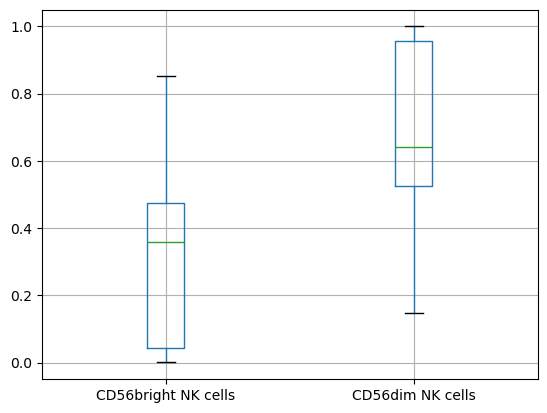

In [18]:
bp_plot = pd.DataFrame(theta_state_df[['CD56bright NK cells', 'CD56dim NK cells']].T/theta_state_df[['CD56bright NK cells', 'CD56dim NK cells']].sum(axis=1).T).T.boxplot()

In [19]:
figure = bp_plot.get_figure()    
figure.savefig('cd56bright_cd56dim_pancreas_tcga.pdf', dpi=400)

In [19]:
theta_state_groups = theta_state_df[['CD56bright NK cells', 'CD56dim NK cells']].copy()

In [20]:
theta_type_immune = theta_type_df[['T cells', 'Myeloid', 'B cells', 'NK cells', 'ILC']].copy()

In [21]:
theta_type_immune.index = ['-'.join(x.split('-')[:3]) for x in theta_type_immune.index]

In [22]:
theta_type_immune = theta_type_immune[~theta_type_immune.index.duplicated(keep='first')]

In [23]:
theta_state_groups.index = ['-'.join(x.split('-')[:3]) for x in theta_state_groups.index]

In [24]:
theta_state_groups = theta_state_groups[~theta_state_groups.index.duplicated(keep='first')]

In [25]:
theta_state_groups_fraction = (theta_state_groups.T/theta_state_groups.sum(axis=1)).T.copy()

In [26]:
theta_type_immune_fraction = (theta_type_immune.T/theta_type_immune.sum(axis=1)).T.copy()

#### Clinical PAAD

In [27]:
%%R -o clin_paad
clin_paad <- clin.dat

In [28]:
paad_survival_df = pd.read_csv('/tumor-data/survival%2FPAAD_survival.txt', sep='\t')

In [29]:
paad_survival_df = paad_survival_df.drop_duplicates(subset='_PATIENT')

In [30]:
clin_paad = clin_paad[[x in theta_type_immune.index for x in clin_paad['submitter_id']]]

In [31]:
paad_survival_df.index = paad_survival_df['_PATIENT']

In [32]:
clin_paad = clin_paad[[x in paad_survival_df.index for x in clin_paad['submitter_id']]]

In [33]:
paad_survival_df = paad_survival_df.loc[clin_paad['submitter_id']].copy()

In [34]:
clin_paad.loc[:,paad_survival_df.columns] = paad_survival_df.values

/tmp/ipykernel_1091680/1864932030.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clin_paad.loc[:,paad_survival_df.columns] = paad_survival_df.values


In [35]:
clin_paad['total_nk'] = ['high' if x in theta_type_immune.sort_values('NK cells')[-int(theta_type_immune.shape[0]/2):].index 
                        else 'low' if x in theta_type_immune.sort_values('NK cells')[:int(theta_type_immune.shape[0]/2)].index else 'middle' for x in clin_paad['submitter_id']]

In [36]:
cell_state='CD56bright NK cells'
clin_paad['cd56bright'] = ['high' if x in theta_state_groups.sort_values(cell_state)[-int(theta_state_groups.shape[0]/2):].index 
                                          else 'low' if x in theta_state_groups.sort_values(cell_state)[:int(theta_state_groups.shape[0]/2)].index else 'middle' for x in clin_paad['submitter_id']]

In [37]:
cell_state='CD56dim NK cells'
clin_paad['cd56dim'] = ['high' if x in theta_state_groups.sort_values(cell_state)[-int(theta_state_groups.shape[0]/2):].index 
                                          else 'low' if x in theta_state_groups.sort_values(cell_state)[:int(theta_state_groups.shape[0]/2)].index else 'middle' for x in clin_paad['submitter_id']]

#### Stratify by NK, CD56bright and CD56dim

In [146]:
test_group='cd56bright'

In [147]:
clin_paad_test = clin_paad[clin_paad[f'{test_group}'] != 'middle'].copy()

In [148]:
%%R
library(survival)
library("survminer")

In [149]:
%%R -i clin_paad_test
clin_paad_test$OS=as.numeric(clin_paad_test$OS)
clin_paad_test$OS.time=as.numeric(clin_paad_test$OS.time)

clin_paad_test$OS.time <- clin_paad_test$OS.time / 365

clin_paad_test$OS[clin_paad_test$OS.time>7] <- 0
clin_paad_test$OS.time[clin_paad_test$OS.time>7] <- 7

clin_paad_test$OS.use=clin_paad_test$OS
clin_paad_test$OS.time.use=clin_paad_test$OS.time

In [158]:
%%R
cox = coxph(Surv(OS.time.use,OS.use) ~ g1g3 + gender + age_at_index + ajcc_pathologic_stage, data=clin_paad_test)

In [151]:
%%R -i test_group
#form = as.formula(paste('Surv(OS.time.use,OS.use)', '~', test_group))
fit = survfit(as.formula(paste('Surv(OS.time.use,OS.use)', '~', test_group)), data=clin_paad_test)

In [159]:
%%R
cox

Call:
coxph(formula = Surv(OS.time.use, OS.use) ~ g1g3 + gender + age_at_index + 
    ajcc_pathologic_stage, data = clin_paad_test)

                                     coef  exp(coef)   se(coef)      z      p
g1g3hi_lo                       4.949e-01  1.640e+00  3.153e-01  1.570 0.1164
g1g3lo_hi                      -1.035e-01  9.016e-01  3.326e-01 -0.311 0.7556
g1g3lo_lo                      -9.795e-03  9.903e-01  3.594e-01 -0.027 0.9783
gendermale                     -2.485e-01  7.800e-01  2.131e-01 -1.166 0.2436
age_at_index                    2.134e-02  1.022e+00  1.031e-02  2.069 0.0385
ajcc_pathologic_stageStage IA   1.620e+01  1.084e+07  2.319e+03  0.007 0.9944
ajcc_pathologic_stageStage IB   1.544e+01  5.063e+06  2.319e+03  0.007 0.9947
ajcc_pathologic_stageStage IIA  1.600e+01  8.886e+06  2.319e+03  0.007 0.9945
ajcc_pathologic_stageStage IIB  1.652e+01  1.494e+07  2.319e+03  0.007 0.9943
ajcc_pathologic_stageStage III  1.568e+01  6.484e+06  2.319e+03  0.007 0.9946
ajcc_path

In [153]:
%%R
fit

Call: survfit(formula = as.formula(paste("Surv(OS.time.use,OS.use)", 
    "~", test_group)), data = clin_paad_test)

                 n events median 0.95LCL 0.95UCL
cd56bright=high 89     37   1.92    1.65      NA
cd56bright=low  89     56   1.42    1.25    1.81


#### Score NK cell states

In [66]:
from pyscenic.aucell import aucell
from ctxcore.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

In [68]:
all_groups_deg = pd.read_csv('nhood_markers_all.csv')

In [69]:
for group in range(1,7):
    all_groups_deg[f'rank_{group}'] = all_groups_deg[f'logFC_{group}']*-np.log10(all_groups_deg[f'adj.P.Val_{group}'])

In [70]:
group = 1
g1_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [71]:
group = 2
g2_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [72]:
group = 3
g3_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [73]:
group = 4
g4_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [74]:
group = 5
g5_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [75]:
group = 6
g6_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-30:]['GeneID'])

In [76]:
signature_genes = [g1_sig,g2_sig,g3_sig,g4_sig,g5_sig,g6_sig]
signature_names = [f'g{x}' for x in range(1,7)]

In [77]:
gene_sigs = [GeneSignature(name,genes) for (name,genes) in zip(signature_names, signature_genes)]

In [78]:
exp_df = Z_nk_adata.to_df()#pd.DataFrame(adata.X.todense(), columns=adata.var.index, index=adata.obs.index)

In [79]:
import random

In [80]:
random.seed(0)

In [81]:
auc_mtx = aucell(exp_df, gene_sigs, num_workers=4)

In [82]:
auc_mtx.index = ['-'.join(x.split('-')[:3]) for x in auc_mtx.index]

In [83]:
auc_mtx = auc_mtx[~auc_mtx.index.duplicated(keep='first')]

In [84]:
auc_mtx = auc_mtx.loc[clin_paad['submitter_id']]

In [85]:
for i in range(1,7):
    nk_state=i
    clin_paad[f'g{nk_state}'] = ['high' if x in auc_mtx.sort_values(f'g{nk_state}')[-int(auc_mtx.shape[0]/2):].index 
                                else 'low' if x in auc_mtx.sort_values(f'g{nk_state}')[:int(auc_mtx.shape[0]/2)].index else 'middle' for x in clin_paad['submitter_id']]

In [86]:
clin_paad['g1g3'] = [f'{x[:2]}_{y[:2]}' for x,y in zip(clin_paad['g1'], clin_paad['g3'])]

In [87]:
clin_paad_test = clin_paad[clin_paad['g1g3'].isin(['lo_hi', 'hi_lo'])].copy()

In [88]:
%%R
library(survival)
library("survminer")

In [89]:
%%R -i clin_paad_test
clin_paad_test$OS=as.numeric(clin_paad_test$OS)
clin_paad_test$OS.time=as.numeric(clin_paad_test$OS.time)

clin_paad_test$OS.time <- clin_paad_test$OS.time / 365

clin_paad_test$OS[clin_paad_test$OS.time>7] <- 0
clin_paad_test$OS.time[clin_paad_test$OS.time>7] <- 7

clin_paad_test$OS.use=clin_paad_test$OS
clin_paad_test$OS.time.use=clin_paad_test$OS.time

In [90]:
#%%R
#cox = coxph(Surv(OS.time.use,OS.use) ~ g1 + gender + age_at_index + ajcc_pathologic_stage, data=clin_paad_test)

In [91]:
%%R
fit = survfit(Surv(OS.time.use,OS.use) ~ g1g3, data=clin_paad_test)